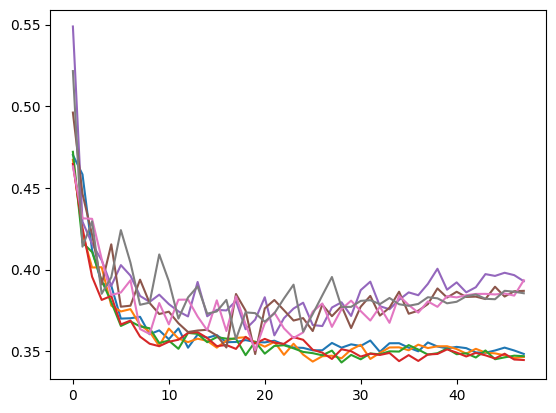

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"model-{fold}/history.csv")
    
    # plt.plot(df.epoch, df.train_loss, label='train_loss')
    plt.plot(df.epoch, df.valid_loss, label='valid_loss')


max_acc: 0.859997034072876


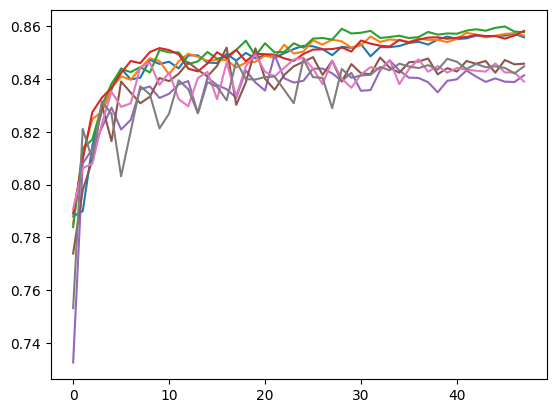

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


max_acc = 0.0
# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"model-{fold}/history.csv")
    
    plt.plot(df.epoch, df.multi_label_accuracy, label='multi_label_accuracy')

    if np.max(df.multi_label_accuracy) > max_acc:
        max_acc = np.max(df.multi_label_accuracy)

print(f"max_acc: {max_acc}")

min_hamming: 0.1400030974136595


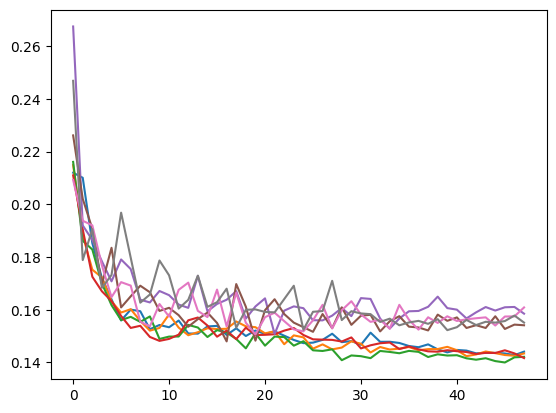

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


min_hamming = 1.0
# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"model-{fold}/history.csv")
    
    plt.plot(df.epoch, df.multilabel_hamming_loss, label='multilabel_hamming_loss')

    if np.min(df.multilabel_hamming_loss) < min_hamming:
        min_hamming = np.min(df.multilabel_hamming_loss)

print(f"min_hamming: {min_hamming}")

max_f1_score: 0.647354173941335


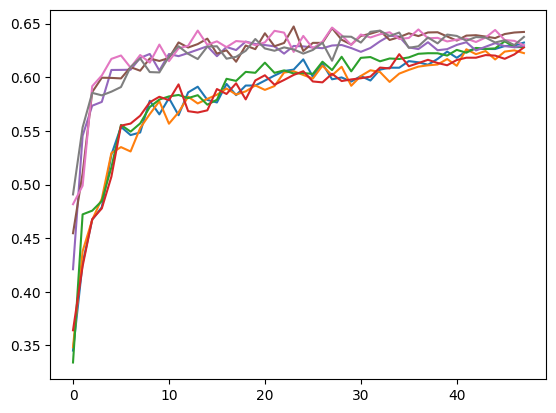

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


max_f1_score = 0.0
# load history.csv
for fold in range(1, 9):
    df = pd.read_csv(f"model-{fold}/history.csv")
    
    plt.plot(df.epoch, df.macro_f1_score_multilabel, label='macro_f1_score_multilabel')

    if np.max(df.macro_f1_score_multilabel) > max_f1_score:
        max_f1_score = np.max(df.macro_f1_score_multilabel)

print(f"max_f1_score: {max_f1_score}")

In [5]:
import sys
sys.path.append('../../src')
sys.path.append('../../')
import json



config_file_path = "config.json"
with open(config_file_path, "r") as f:
    config_data = json.load(f)

config_data['PATH'] = '/home/viktor/Documents/idoven/idoven-challenge/data/physionet.org/files/ptb-xl/1.0.2/'
config_data['LMAX_VALIDATION'] = 768

config_data

{'OUT': 'experiments/baseline-plus-augms-manymodels/',
 'PATH': '/home/viktor/Documents/idoven/idoven-challenge/data/physionet.org/files/ptb-xl/1.0.2/',
 'TEST_FOLDS': [9, 10],
 'NUM_WORKERS_DATALOADER': 4,
 'SEED': 42,
 'BATCH_SIZE': 64,
 'BATCH_SIZE_EFFECTIVE': 64,
 'LMAX': 384,
 'LMAX_VALIDATION': 768,
 'AUGMENT': True,
 'TRAIN_ON_FFTS': False,
 'NFFT_COMPONENTS': 192,
 'USE_WEIGHTED_SAMPLER': False,
 'EPOCHS': 48,
 'LR_MAX': 0.0003,
 'MODEL': 'DeepHeartModel',
 'DIV': 25,
 'DIV_FINAL': 25,
 'MOMS': [0.95, 0.95, 0.95],
 'EMA': False,
 'MODEL_KWARGS': {'dim': 192,
  'dim_base': 128,
  'depth': 12,
  'head_size': 4,
  'drop_path': 0.2},
 'WEIGHTS': False,
 'LOSS_FUNC': 'binary_cross_entropy',
 'METRICS': ['multi_label_accuracy',
  'multilabel_hamming_loss',
  'macro_f1_score_multilabel']}

In [6]:
from models import DeepHeartModel
model = DeepHeartModel(**config_data["MODEL_KWARGS"]);

In [7]:
import torch
from dataloaders import ECGDataset

models = {}

ds_val = ECGDataset(
    path=config_data["PATH"],
    mode="val",
    L=config_data["LMAX_VALIDATION"],
    test_folds=[9,10],
)

for model_indx in range(1, 9):
    
    print(f"Loading model for model {model_indx} ... ")
    loaded_weights = torch.load(f"model-{model_indx}/models/model_41.pth")
    
    
    _model = DeepHeartModel(**config_data["MODEL_KWARGS"])
    _model.load_state_dict(loaded_weights, strict=True)
    _model = _model.cuda()
    models[model_indx] = _model
    
    
    
    
    

[INFO] Loading data...
[INFO] Obtaining diagnostic_superclass for val mode ...
X.shape: (4306, 1000, 12), y.shape: (4306, 5)
X.min: -11.416, X.max: 12.966
Loading model for model 1 ... 
Loading model for model 2 ... 
Loading model for model 3 ... 
Loading model for model 4 ... 
Loading model for model 5 ... 
Loading model for model 6 ... 
Loading model for model 7 ... 
Loading model for model 8 ... 


In [8]:
len(ds_val)

4306

In [9]:
from tqdm import tqdm

# loop through ds_val

y_true_batch = []
y_pred_batch = []
model_preds = {}

for fold in range(1, 9):
    model_preds[fold] = []

for i, out in enumerate(tqdm(ds_val, total=len(ds_val))):
    
    x, y = out[0], out[1]
    
    # send to device
    x['x'] = torch.unsqueeze(x['x'], 0).cuda()
    y['y'] = torch.unsqueeze(y['y'], 0).cuda()
    
    
    y_pred = []
    # get the model predictions
    for fold in range(1, 9):
        pred = torch.sigmoid(models[fold](x))
        y_pred.append(pred)
        model_preds[fold].append(pred.cpu().detach().squeeze().numpy())
        
        
    
    # average the predictions
    y_pred = torch.stack(y_pred).mean(dim=0)
    
    # convert to numpy
    y_pred_np = y_pred.cpu().detach().squeeze().numpy()
    
    # get y_true_np
    y_true_np = y['y'].cpu().detach().squeeze().numpy().astype(int)
    
    # append to batch
    y_true_batch.append(y_true_np)
    y_pred_batch.append(y_pred_np)
    
    
    # if i > 100:
    #     break

100%|██████████| 4306/4306 [03:05<00:00, 23.21it/s]


In [10]:
y_true_batch_torch = {'y': torch.tensor(y_true_batch)}
y_pred_batch_torch = torch.tensor(y_pred_batch)

for fold in range(1, 9):
    model_preds[fold] = torch.tensor(model_preds[fold])

/tmp/ipykernel_449108/3120016003.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343997789/work/torch/csrc/utils/tensor_new.cpp:245.)
  y_true_batch_torch = {'y': torch.tensor(y_true_batch)}


In [11]:
model_preds[1].shape, y_pred_batch_torch.shape

(torch.Size([4306, 5]), torch.Size([4306, 5]))

In [12]:
from metrics import multi_label_accuracy, multilabel_hamming_loss, macro_f1_score_multilabel, pr_auc_multilabel, auroc_multilabel

acc = multi_label_accuracy(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
hamming_loss = multilabel_hamming_loss(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
f1_score = macro_f1_score_multilabel(y_pred_batch_torch, y_true_batch_torch, threshold=0.5, apply_sigmoid=False)
pr_auc = pr_auc_multilabel(y_pred_batch_torch, y_true_batch_torch, apply_sigmoid=False)
auroc = auroc_multilabel(y_pred_batch_torch, y_true_batch_torch, apply_sigmoid=False)

acc, hamming_loss, f1_score, pr_auc, auroc

(tensor(0.8590),
 0.1410125406409661,
 0.6478909673541633,
 0.7214513335065054,
 0.8800674210113193)

In [13]:
y_true_batch_torch['y'].shape

torch.Size([4306, 5])

In [58]:
from sklearn.metrics import f1_score,fbeta_score

ths = np.arange(0.01, 1.0, 0.01)
accs = []
hamming_losses = []
f1_scores = []
pr_aucs = []
aurocs = []
per_class_f1_score = {}
per_class_fbeta_score = {}


# calculate per_class_f1_score
n_classes = y_pred_batch_torch.size(1)
    
    
for class_idx in range(n_classes):
    per_class_f1_score[class_idx] = []
    per_class_fbeta_score[class_idx] = []

accs_model = {}
hamming_losses_model = {}
f1_scores_model = {}
pr_aucs_model = {}
aurocs_model = {}

for fold in range(1, 9):
    accs_model[fold] = []
    hamming_losses_model[fold] = []
    f1_scores_model[fold] = []
    pr_aucs_model[fold] = []
    aurocs_model[fold] = []

for th in tqdm(ths):
    
    acc = multi_label_accuracy(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    hamming_loss = multilabel_hamming_loss(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    f1_score_val = macro_f1_score_multilabel(y_pred_batch_torch, y_true_batch_torch, threshold=th, apply_sigmoid=False)
    pr_auc = pr_auc_multilabel(y_pred_batch_torch, y_true_batch_torch,  apply_sigmoid=False)
    auroc = auroc_multilabel(y_pred_batch_torch, y_true_batch_torch, apply_sigmoid=False)
    
    
    
    
    for class_idx in range(n_classes):
        y_true = y_true_batch_torch['y'].cpu().numpy()[:, class_idx]
        y_pred = y_pred_batch_torch.cpu().numpy()[:, class_idx] > th
        
        per_class_f1_score[class_idx].append(f1_score(y_true, y_pred))
        per_class_fbeta_score[class_idx].append(fbeta_score(y_true, y_pred, beta=0.25))


    accs.append(acc.item())
    hamming_losses.append(hamming_loss)
    f1_scores.append(f1_score_val)
    pr_aucs.append(pr_auc)
    aurocs.append(auroc)
    
    # evaluate each of the models
    for fold in range(1, 9):
        acc = multi_label_accuracy(model_preds[fold], y_true_batch_torch, threshold=th, apply_sigmoid=False)
        hamming_loss = multilabel_hamming_loss(model_preds[fold], y_true_batch_torch, threshold=th, apply_sigmoid=False)
        f1_score_val = macro_f1_score_multilabel(model_preds[fold], y_true_batch_torch, threshold=th, apply_sigmoid=False)
        pr_auc = pr_auc_multilabel(model_preds[fold], y_true_batch_torch, apply_sigmoid=False)
        auroc = auroc_multilabel(model_preds[fold], y_true_batch_torch, apply_sigmoid=False)
        
        accs_model[fold].append(acc.item())
        hamming_losses_model[fold].append(hamming_loss)
        f1_scores_model[fold].append(f1_score_val)
        pr_aucs_model[fold].append(pr_auc)
        aurocs_model[fold].append(auroc)


100%|██████████| 99/99 [00:08<00:00, 12.34it/s]


(0.8, 0.92)

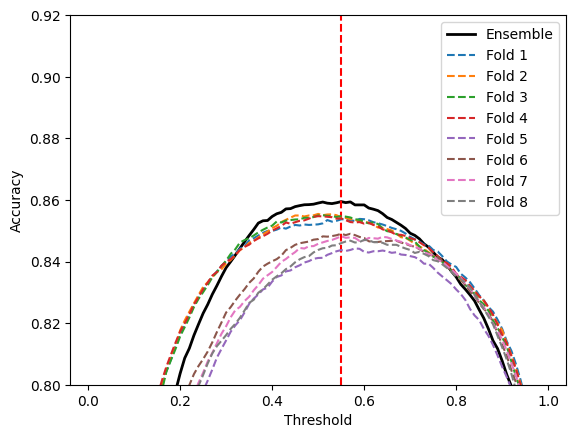

In [48]:
plt.plot(ths, accs, color='black', lw=2, label='Ensemble')
idx_max = np.argmax(accs)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_max], color='r', linestyle='--')

for fold in range(1, 9):
    plt.plot(ths, accs_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

plt.ylabel('Accuracy')
plt.xlabel('Threshold')
plt.ylim(0.8, 0.92)

(0.12, 0.2)

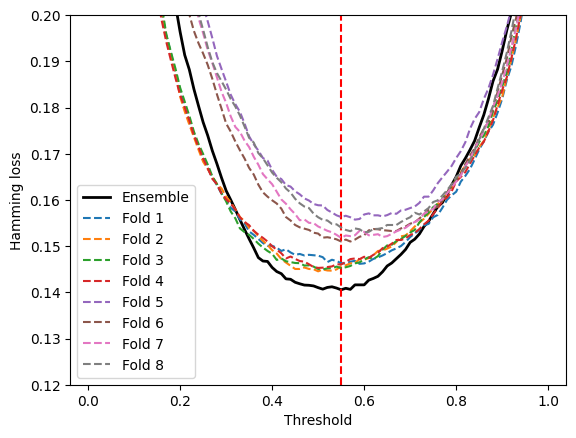

In [49]:
plt.plot(ths, hamming_losses, color='black', lw=2, label='Ensemble')
idx_min = np.argmin(hamming_losses)
# plot vertical line at max accuracy
plt.axvline(x=ths[idx_min], color='r', linestyle='--')

for fold in range(1, 9):
    plt.plot(ths, hamming_losses_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

plt.ylabel('Hamming loss')
plt.xlabel('Threshold')
plt.ylim(0.12, 0.2)


Max f1 score: 0.6711358998406111


(0.58, 0.68)

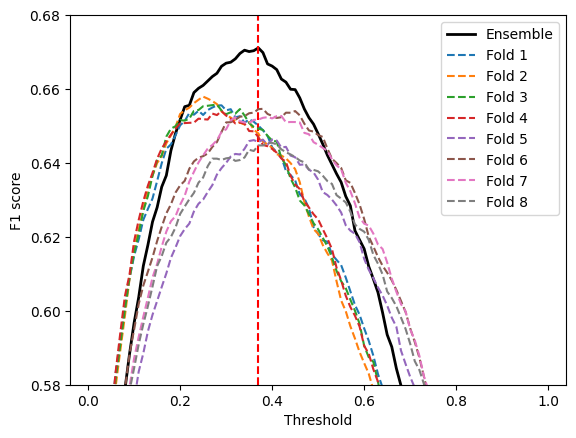

In [50]:

plt.plot(ths, f1_scores, color='black', lw=2, label='Ensemble')
idx_max = np.argmax(f1_scores)

print(f"Max f1 score: {np.max(f1_scores)}")

# plot vertical line at max accuracy
plt.axvline(x=ths[idx_max], color='r', linestyle='--')

for fold in range(1, 9):
    plt.plot(ths, f1_scores_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

plt.ylabel('F1 score')
plt.xlabel('Threshold')
plt.ylim(0.58, 0.68)

Text(0.5, 0, 'Threshold')

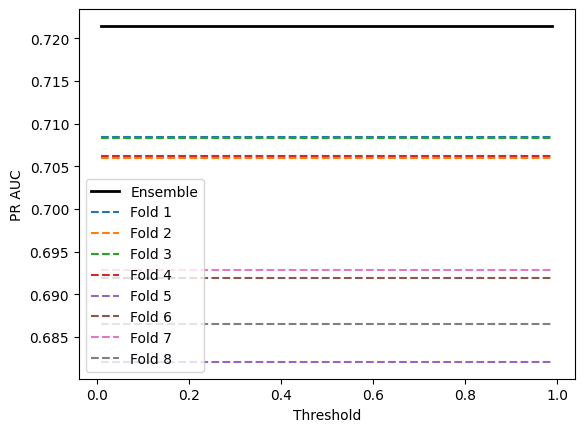

In [51]:
plt.plot(ths, pr_aucs, color='black', lw=2, label='Ensemble')

for fold in range(1, 9):
    plt.plot(ths, pr_aucs_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

plt.ylabel('PR AUC')
plt.xlabel('Threshold')
# plt.ylim(0.58, 0.65)

Ensemble AUROC: 0.8800674210113193


Text(0, 0.5, 'AUROC')

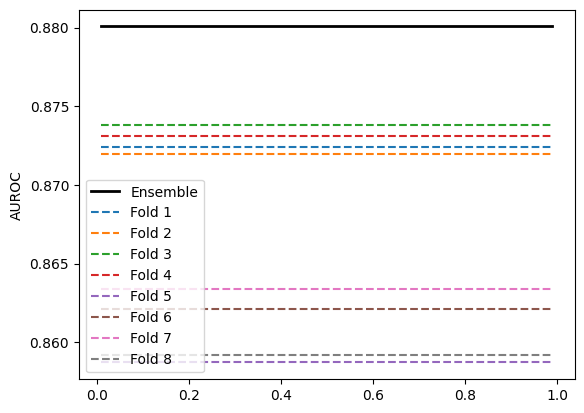

In [52]:
plt.plot(ths, aurocs, color='black', lw=2, label='Ensemble')

for fold in range(1, 9):
    plt.plot(ths, aurocs_model[fold], label=f'Fold {fold}', ls='--')


plt.legend()

print(f'Ensemble AUROC: {aurocs[-1]}')


plt.ylabel('AUROC')
# plt.ylim(0.58, 0.65)

# Per class F1 score

Best th for class ['CD']: 0.36000000000000004
Best th for class ['HYP']: 0.21000000000000002
Best th for class ['MI']: 0.34
Best th for class ['NORM']: 0.4
Best th for class ['STTC']: 0.36000000000000004


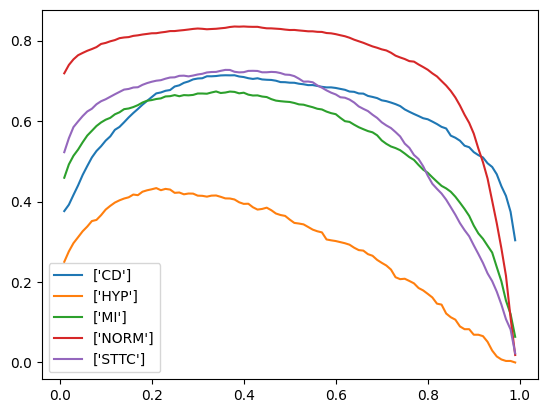

In [64]:
from dataloaders import decode_label

best_thresholds_f1_score = []

for class_indx in range(5):
    class_indx_onehot = np.zeros(5)
    class_indx_onehot[class_indx] = 1
    class_decoded = decode_label(class_indx_onehot, ds_val.unique_superclasses)
    plt.plot(ths, per_class_f1_score[class_indx], label=class_decoded)
    
    # print best th per class
    best_th = ths[np.argmax(per_class_f1_score[class_indx])]
    print(f'Best th for class {class_decoded}: {best_th}')
    
    best_thresholds_f1_score.append(best_th)
    
    
plt.legend()

Best th for class ['CD']: 0.9500000000000001
Best th for class ['HYP']: 0.68
Best th for class ['MI']: 0.78
Best th for class ['NORM']: 0.8400000000000001
Best th for class ['STTC']: 0.72


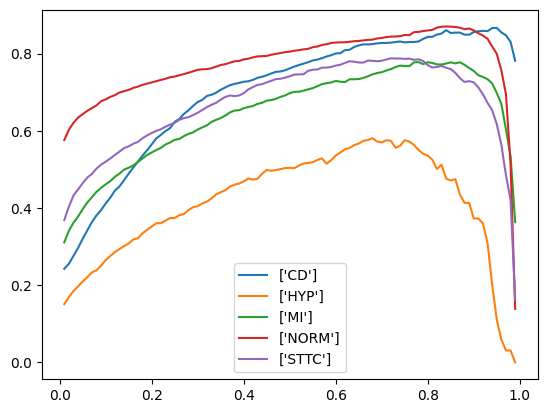

In [63]:
from dataloaders import decode_label

best_thresholds_fbeta_score = []

for class_indx in range(5):
    class_indx_onehot = np.zeros(5)
    class_indx_onehot[class_indx] = 1
    class_decoded = decode_label(class_indx_onehot, ds_val.unique_superclasses)
    plt.plot(ths, per_class_fbeta_score[class_indx], label=class_decoded)
    
    # print best th per class
    best_th = ths[np.argmax(per_class_fbeta_score[class_indx])]
    print(f'Best th for class {class_decoded}: {best_th}')
    
    best_thresholds_fbeta_score.append(best_th)
    
    
plt.legend()

# Confusion matrix

To be compared with 2202.00567 (https://arxiv.org/abs/2202.00567)


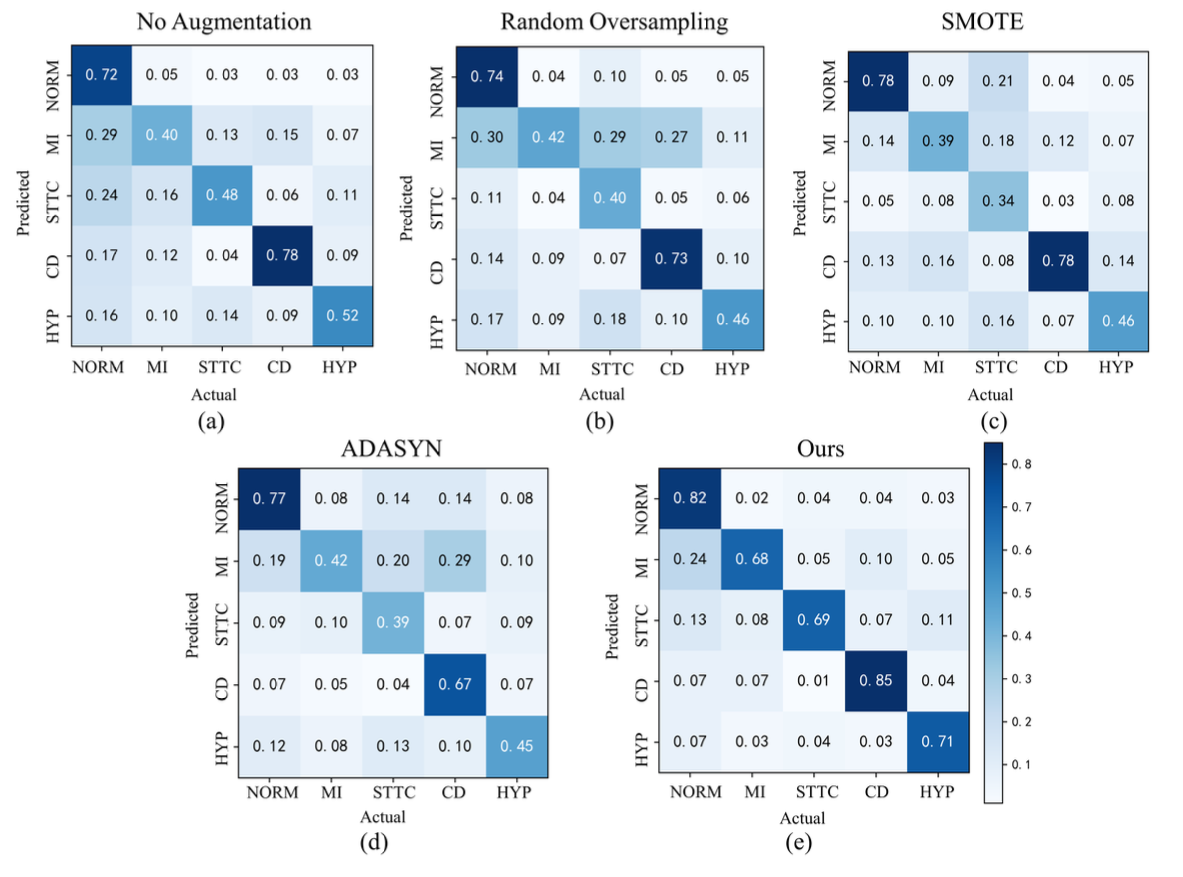

In [21]:
y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()

y_true_np.shape, y_pred_np.shape 

# Construct a confusion matrix for each class

((4306, 5), (4306, 5))

In [22]:
y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()

y_true_np.shape, y_pred_np.shape

((4306, 5), (4306, 5))

# threshold by best f1 score

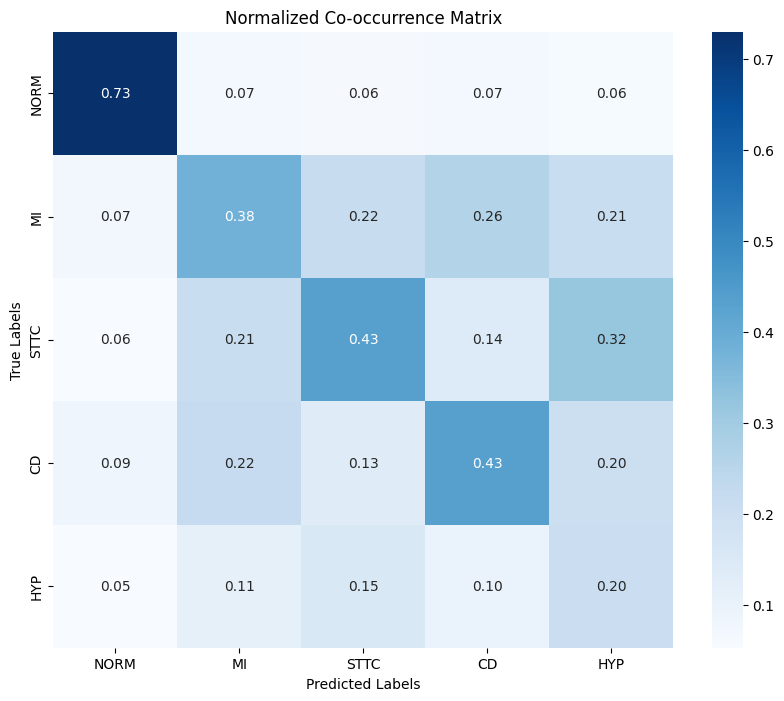

In [65]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


co_occurrence_matrix = np.zeros((5, 5))

for i in range(5):
    
    for j in range(5):
        
        co_occurrence_matrix[i, j] = np.sum(np.logical_and(y_true_np[:, i] == 1, y_pred_np[:, j] > best_thresholds_f1_score[j]))
        


# Normalize columns
column_sums = co_occurrence_matrix.sum(axis=0)
co_occurrence_matrix_normalized = co_occurrence_matrix / column_sums[np.newaxis, :]

# Adjust row and column order
desired_order = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
current_order = ds_val.unique_superclasses

reordered_matrix = np.zeros((5, 5))
for i, row_class in enumerate(desired_order):
    for j, col_class in enumerate(desired_order):
        row_index_in_current_order = current_order.index(row_class)
        col_index_in_current_order = current_order.index(col_class)
        reordered_matrix[i, j] = co_occurrence_matrix_normalized[row_index_in_current_order, col_index_in_current_order]

# Visualizing
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Co-occurrence Matrix")
plt.show()


# threshold by best fbeta score

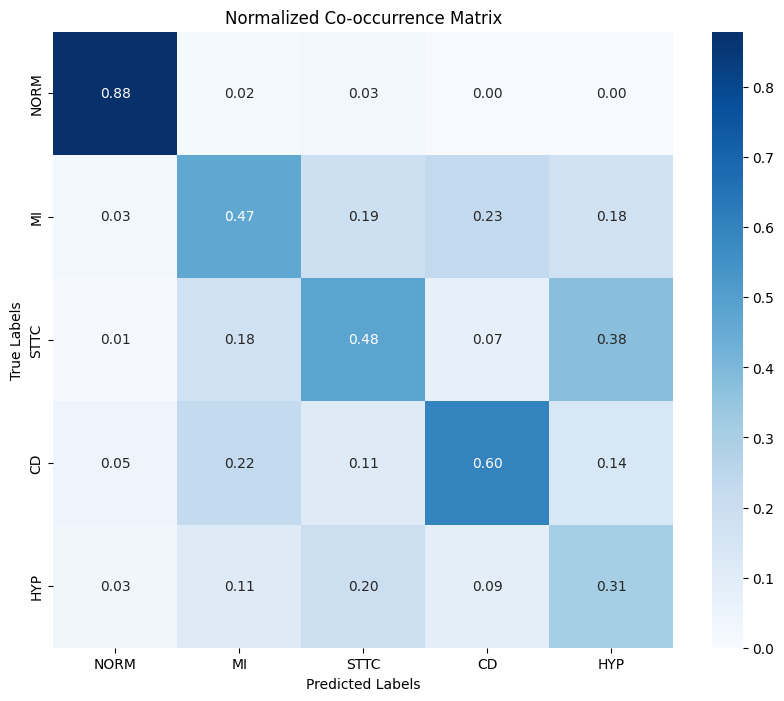

In [66]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


co_occurrence_matrix = np.zeros((5, 5))

for i in range(5):
    
    for j in range(5):
        
        co_occurrence_matrix[i, j] = np.sum(np.logical_and(y_true_np[:, i] == 1, y_pred_np[:, j] > best_thresholds_fbeta_score[j]))
        


# Normalize columns
column_sums = co_occurrence_matrix.sum(axis=0)
co_occurrence_matrix_normalized = co_occurrence_matrix / column_sums[np.newaxis, :]

# Adjust row and column order
desired_order = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
current_order = ds_val.unique_superclasses

reordered_matrix = np.zeros((5, 5))
for i, row_class in enumerate(desired_order):
    for j, col_class in enumerate(desired_order):
        row_index_in_current_order = current_order.index(row_class)
        col_index_in_current_order = current_order.index(col_class)
        reordered_matrix[i, j] = co_occurrence_matrix_normalized[row_index_in_current_order, col_index_in_current_order]

# Visualizing
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Co-occurrence Matrix")
plt.show()


# threshold = 0.5

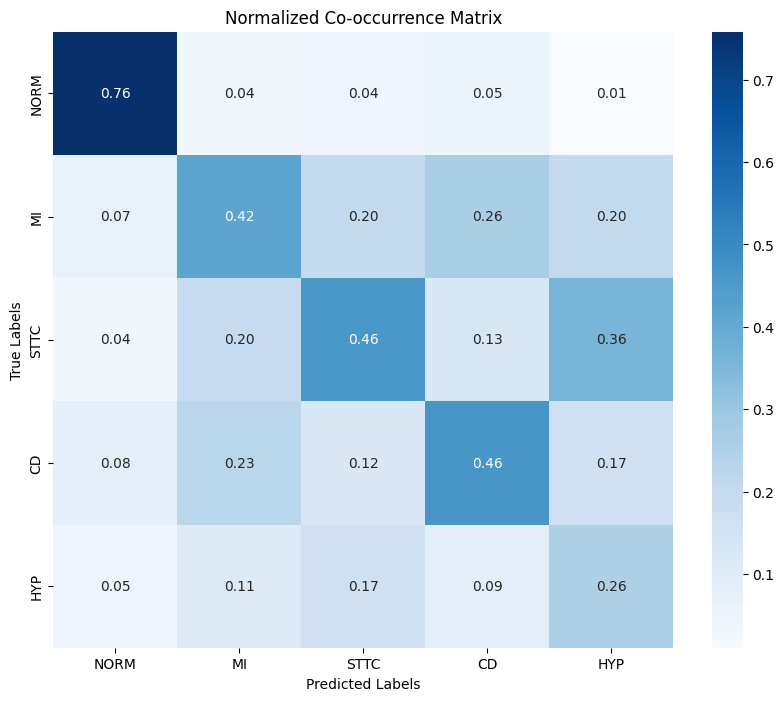

In [61]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


co_occurrence_matrix = np.zeros((5, 5))

for i in range(5):
    for j in range(5):
        co_occurrence_matrix[i, j] = np.sum(np.logical_and(y_true_np[:, i] == 1, y_pred_np[:, j] > 0.5))
        


# Normalize columns
column_sums = co_occurrence_matrix.sum(axis=0)
co_occurrence_matrix_normalized = co_occurrence_matrix / column_sums[np.newaxis, :]

# Adjust row and column order
desired_order = ['NORM', 'MI', 'STTC', 'CD', 'HYP']
current_order = ds_val.unique_superclasses

reordered_matrix = np.zeros((5, 5))
for i, row_class in enumerate(desired_order):
    for j, col_class in enumerate(desired_order):
        row_index_in_current_order = current_order.index(row_class)
        col_index_in_current_order = current_order.index(col_class)
        reordered_matrix[i, j] = co_occurrence_matrix_normalized[row_index_in_current_order, col_index_in_current_order]

# Visualizing
plt.figure(figsize=(10, 8))
sns.heatmap(reordered_matrix, annot=True, fmt=".2f", cmap="Blues", xticklabels=desired_order, yticklabels=desired_order)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Normalized Co-occurrence Matrix")
plt.show()


## Best per-class threshold confusion matrices (f1 score)

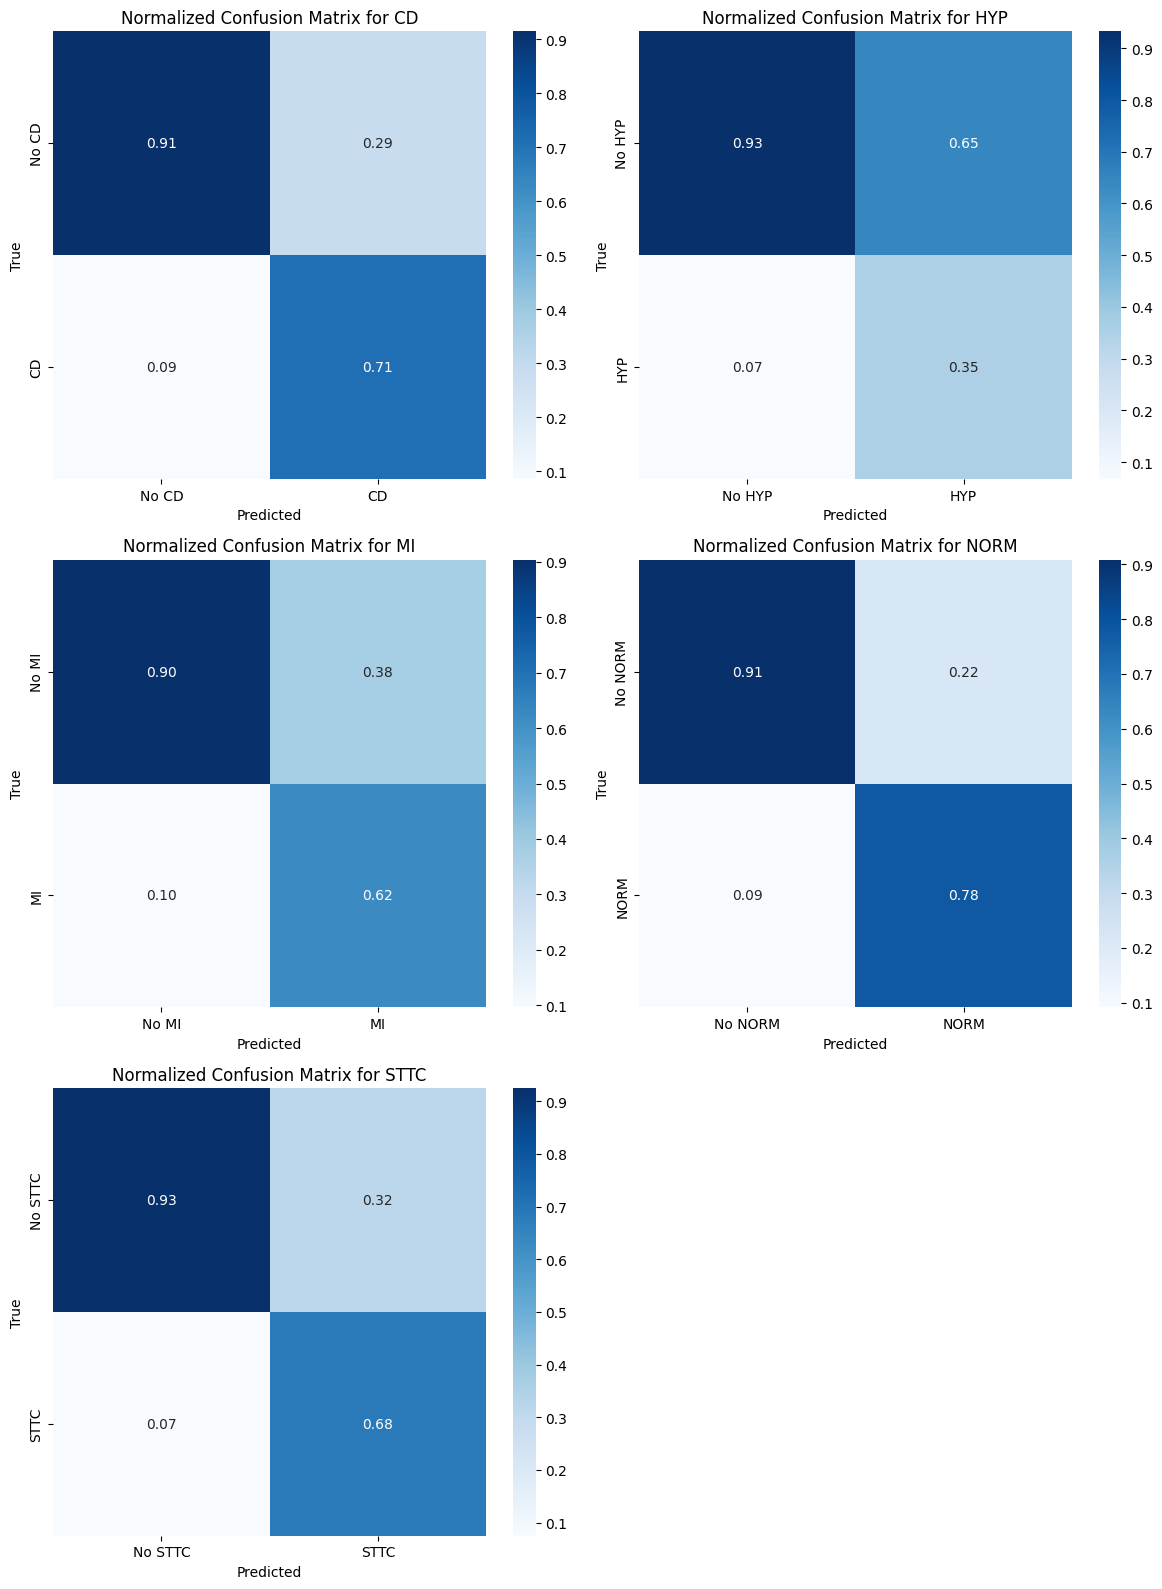

In [67]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()


n_classes = y_true_np.shape[1]
all_confusion_matrices = []

for i in range(n_classes):
    class_true = y_true_np[:, i]
    
    class_pred = (y_pred_np > best_thresholds_f1_score[i]).astype(int)[:, i]
    
    cm = confusion_matrix(class_true, class_pred)
    all_confusion_matrices.append(cm)
    
    
    normalized_confusion_matrices = []

for matrix in all_confusion_matrices:
    # Normalize each row by its sum
    # normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    # normalized_confusion_matrices.append(normalized_matrix)
    
    # Normalize each column by its sum
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=0)[np.newaxis, :]
    normalized_confusion_matrices.append(normalized_matrix)



import matplotlib.pyplot as plt
import seaborn as sns

class_names = ds_val.unique_superclasses

plt.figure(figsize=(12, 16))
for idx, (confusion_mtx, class_name) in enumerate(zip(normalized_confusion_matrices, class_names)):
    plt.subplot(3, 2, idx + 1)  # 3x2 grid
    sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap="Blues", 
                xticklabels=['No ' + class_name, class_name], 
                yticklabels=['No ' + class_name, class_name])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix for {class_name}')

plt.tight_layout()  # to ensure proper spacing between subplots
plt.show()


## Best per-class threshold confusion matrices (fbeta score)

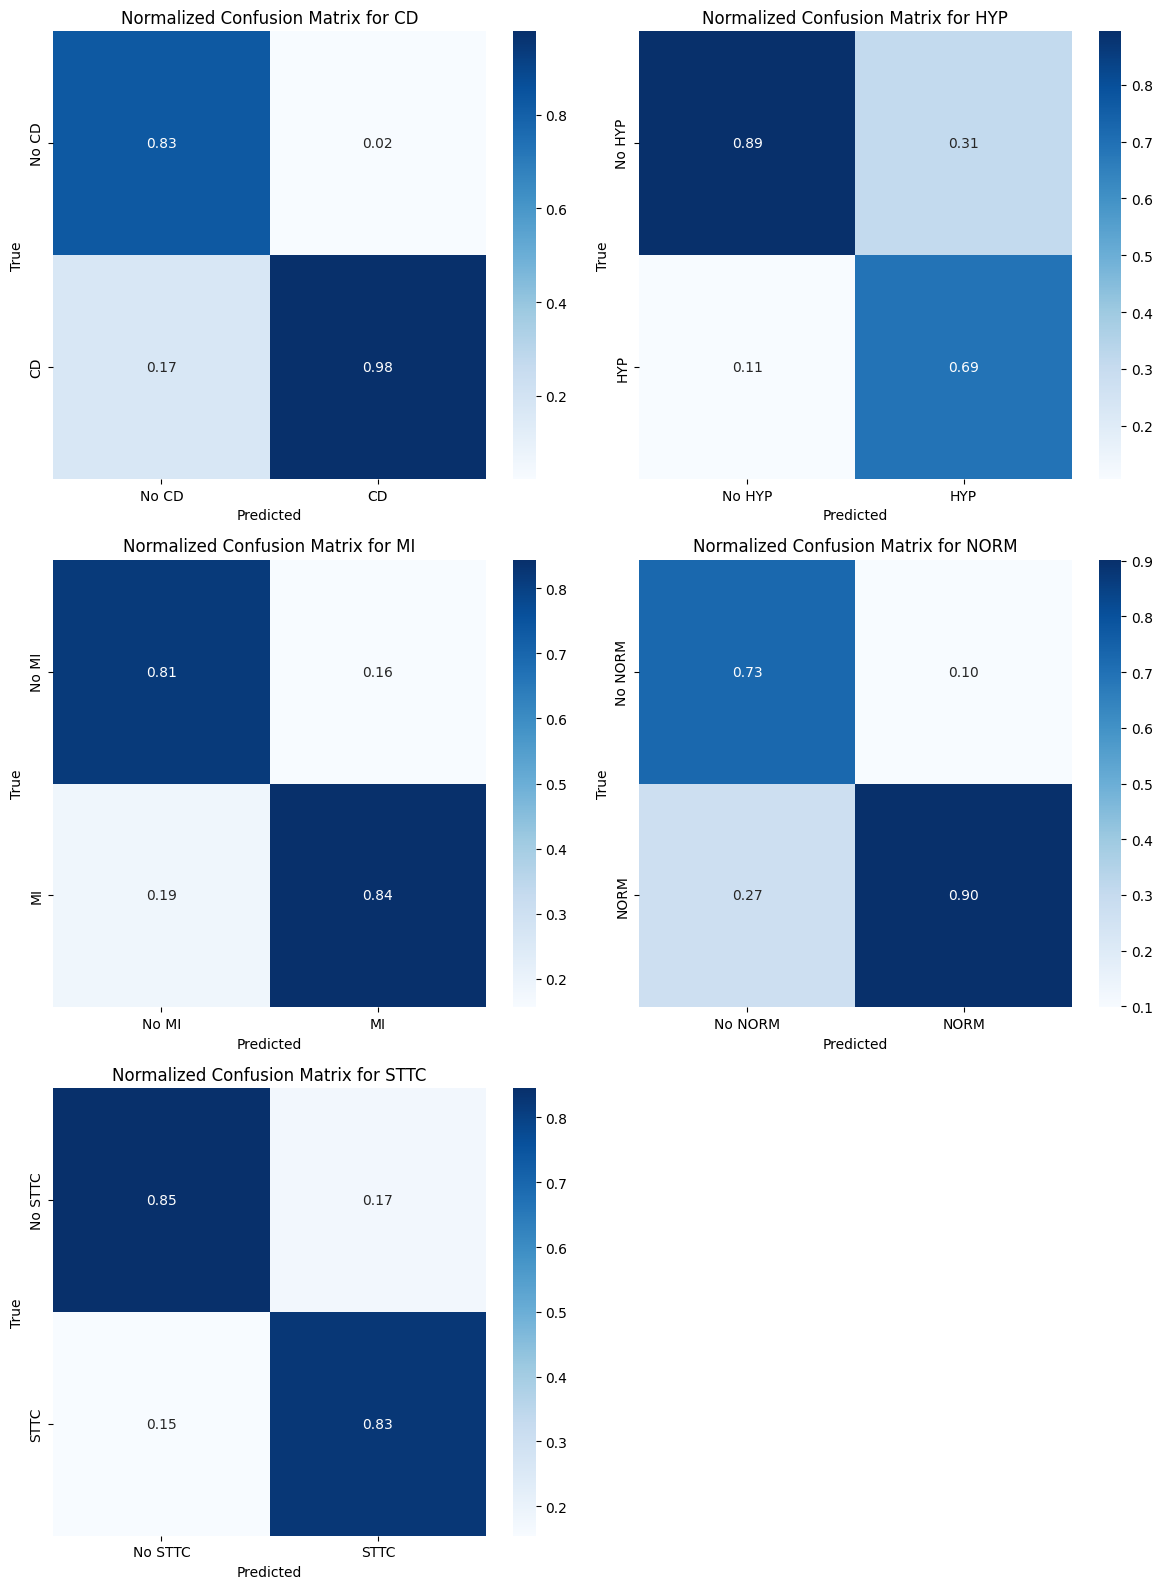

In [68]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()


n_classes = y_true_np.shape[1]
all_confusion_matrices = []

for i in range(n_classes):
    class_true = y_true_np[:, i]
    
    class_pred = (y_pred_np > best_thresholds_fbeta_score[i]).astype(int)[:, i]
    
    cm = confusion_matrix(class_true, class_pred)
    all_confusion_matrices.append(cm)
    
    
    normalized_confusion_matrices = []

for matrix in all_confusion_matrices:
    # Normalize each row by its sum
    # normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    # normalized_confusion_matrices.append(normalized_matrix)
    
    # Normalize each column by its sum
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=0)[np.newaxis, :]
    normalized_confusion_matrices.append(normalized_matrix)



import matplotlib.pyplot as plt
import seaborn as sns

class_names = ds_val.unique_superclasses

plt.figure(figsize=(12, 16))
for idx, (confusion_mtx, class_name) in enumerate(zip(normalized_confusion_matrices, class_names)):
    plt.subplot(3, 2, idx + 1)  # 3x2 grid
    sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap="Blues", 
                xticklabels=['No ' + class_name, class_name], 
                yticklabels=['No ' + class_name, class_name])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix for {class_name}')

plt.tight_layout()  # to ensure proper spacing between subplots
plt.show()


## threshold=0.5 confusion matrices

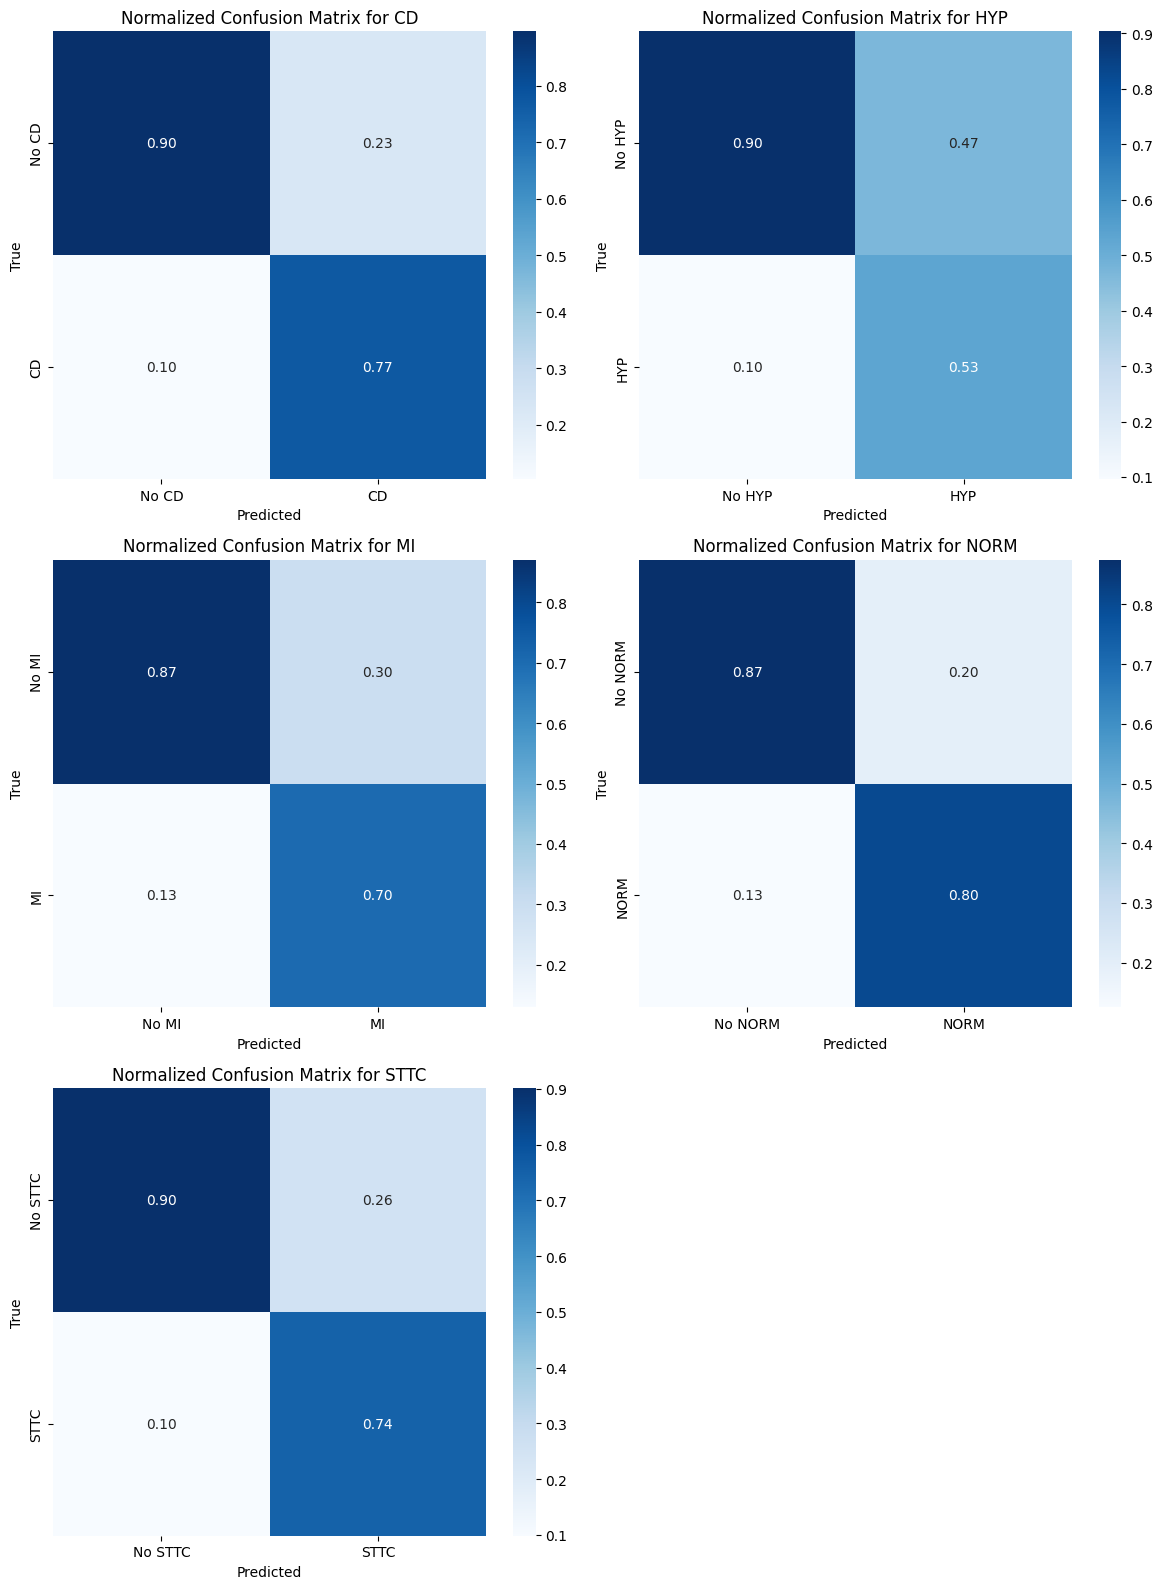

In [30]:
import numpy as np
from sklearn.metrics import confusion_matrix

y_true_np = y_true_batch_torch['y'].cpu().numpy()
y_pred_np = y_pred_batch_torch.cpu().numpy()

# Assuming a threshold of 0.5 to classify predictions
y_pred_bin = (y_pred_np > 0.5).astype(int)

n_classes = y_true_np.shape[1]
all_confusion_matrices = []

for i in range(n_classes):
    class_true = y_true_np[:, i]
    # class_pred = y_pred_bin[:, i]
    
    class_pred = (y_pred_np > 0.5).astype(int)[:, i]
    
    cm = confusion_matrix(class_true, class_pred)
    all_confusion_matrices.append(cm)
    
    
    normalized_confusion_matrices = []

for matrix in all_confusion_matrices:
    # Normalize each row by its sum
    # normalized_matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]
    # normalized_confusion_matrices.append(normalized_matrix)
    
    # Normalize each column by its sum
    normalized_matrix = matrix.astype('float') / matrix.sum(axis=0)[np.newaxis, :]
    normalized_confusion_matrices.append(normalized_matrix)



import matplotlib.pyplot as plt
import seaborn as sns

class_names = ds_val.unique_superclasses

plt.figure(figsize=(12, 16))
for idx, (confusion_mtx, class_name) in enumerate(zip(normalized_confusion_matrices, class_names)):
    plt.subplot(3, 2, idx + 1)  # 3x2 grid
    sns.heatmap(confusion_mtx, annot=True, fmt='.2f', cmap="Blues", 
                xticklabels=['No ' + class_name, class_name], 
                yticklabels=['No ' + class_name, class_name])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Normalized Confusion Matrix for {class_name}')

plt.tight_layout()  # to ensure proper spacing between subplots
plt.show()


Wow :/ 

The model is really having trouble with classes that occur rarely. Maybe I should implement WeightedRandomSampler.